In [57]:
system('sed -i "s/.S.bracken//g" `grep .S.bracken -rl ./S.out/S.count.tsv.tmp`')
system('sed -i "s/taxonomy/Consensus Lineage/g" `grep taxonomy -rl ./S.out/S.count.tsv.tmp`')

In [1]:
rm(list=ls())
library("phyloseq")
library("ggplot2")
library("dada2")
library("tidyverse")
library(MicrobiotaProcess)
library(vegan)
library(ggsci)
library(ape)
library(ggvenn)
# 制作phyloseq对象并保存
aa = "./S.out/S.count.tsv.tmp"
aab = import_qiime(aa)
#导入mapping文件
metadata <- import_qiime_sample_data("./sample.txt")

Warning message:
“package ‘phyloseq’ was built under R version 4.2.2”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dada2’ was built under R version 4.2.3”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.2.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts

In [2]:
aa

[1] "./S.out/S.count.tsv.tmp"

In [7]:
# 序列名添加.fastq后缀
# 修改第一列名为ID
    colnames(metadata)[1] <- "ID"
    # 去除行名中空格
    rownames(metadata) = gsub(" ","",rownames(metadata))
    # rownames(metadata)  = paste(rownames(metadata),".S.bracken",seq = "")
    # 删除空格
    rownames(metadata) = gsub(" ","",rownames(metadata))
    metadata$ID = rownames(metadata)
    # 构建ps对象
    carbom <- merge_phyloseq(metadata, aab)


In [6]:
set.seed(1234)#设置一个随机种子便于重复
rare.data <-  rarefy_even_depth(carbom,replace = TRUE)

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...



ERROR: Error in .local(object, taxa_are_rows): argument "taxa_are_rows" is missing, with no default


In [ ]:
sample_sums(rare.data)

In [ ]:
carbom = rare.data

In [ ]:
# 中位数测序深度归一化reads数目
total <- median(sample_sums(carbom))
standf <- function(x, t=total){round(t * (x / sum(x)))}
carbom <- transform_sample_counts(carbom, standf)
alphaobj <- get_alphaindex(carbom)

In [ ]:
outdir = paste(getwd(),"1.Species_level",sep = "/")
if(dir.exists(outdir)){
  print("dir exists")
}else{
  dir.create(outdir)
}

In [ ]:
alphaobj@sampleda$group  = factor(alphaobj@sampleda$group ,levels = c("WT-NC", "KO-NC", "WT-CLP", "KO-CLP"))

### a多样性

In [ ]:
p_alpha <- ggbox(alphaobj, geom="boxplot",
                 factorNames="group",
                 p_textsize =3,
                 signifmap=FALSE)+ 
scale_color_aaas()+
  theme_bw()+
  geom_point(aes(color =group))+
  scale_fill_aaas() +theme(axis.text.x = element_text(angle = 45,vjust = 0.5,hjust = 0.5))
width = length(unique(alphaobj@sampleda$group))*3
ggsave(p_alpha,file = paste0(outdir,'/','a_diversity.png'),width = width,height = 4)
ggsave(p_alpha,file = paste0(outdir,'/','a_diversity.pdf'),width = width,height = 4)

In [ ]:
p_rare <- ggrarecurve(obj=carbom, 
                      indexNames=c("Observe","Chao1","ACE"), 
                      chunks=30) +
  theme(legend.spacing.y=unit(0.02,"cm"),
        legend.text=element_text(size=4))+
  theme_bw()
p_rare$data$group = factor(p_rare$data$group ,levels = c("WT-NC", "KO-NC", "WT-CLP", "KO-CLP"))

In [ ]:
p2 <- ggplot(p_rare$data,aes(readsNums,value,color = group))+
  geom_point(stat = "summary", fun = mean)+
  geom_smooth()+
  facet_wrap(~Alpha,scale = "free")+
  theme_bw()+
  xlab("Number of sequence")+ylab("alpha metric")+
  scale_color_aaas()+
  scale_fill_aaas()
p2

In [ ]:

ggsave(p2,file = paste0(outdir,'/','Rarefaction_curves.pdf'),width = 10,height = 5)
ggsave(p2,file = paste0(outdir,'/','Rarefaction_curves.png'),width = 10,height = 5)

In [ ]:
### 
OTU = carbom@otu_table
TAX = carbom@tax_table
random_tree <- rtree(ntaxa(carbom), rooted=TRUE, tip.label=taxa_names(carbom))
carbom_tree <- phyloseq(OTU, TAX, metadata, random_tree)
carbom.ord <- ordinate(carbom, method = "PCoA", distance = "bray")

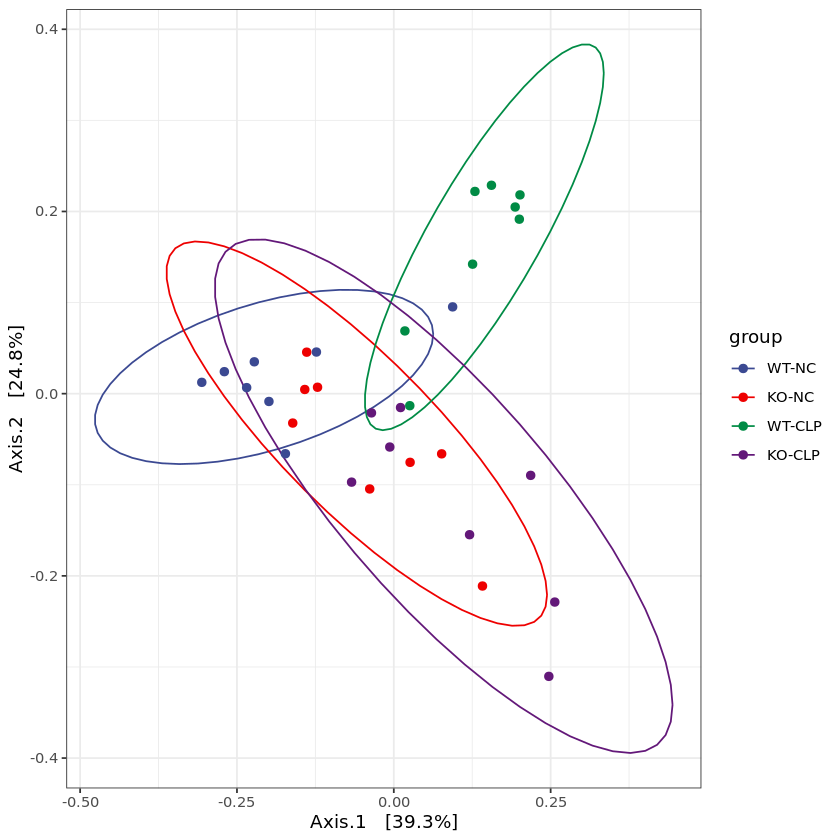

In [64]:
carbom@sam_data[["group"]]<-factor(carbom@sam_data[["group"]],levels = c("WT-NC", "KO-NC", "WT-CLP", "KO-CLP"))
plot_ordination(carbom, carbom.ord, type="samples", color="group")+ 
  stat_ellipse()+ 
  theme_bw()+
  scale_color_aaas()+
  scale_fill_aaas(alpha=0.7)+
  geom_point(size = 2)

In [65]:
ggsave(file = paste0(outdir,'/','ordination_PCoa.pdf'),width = 5,height = 5)
ggsave(file = paste0(outdir,'/','ordination_PCoa.png'),width = 5,height = 5)

In [227]:
groupinfo = read.table('./sample.txt',header =T)
type = rank_names(carbom)
for (i in c(1,2,3,4,5,6,7)){ 
phytax <- get_taxadf(obj=carbom, taxlevel=i)
df = rownames_to_column(as.data.frame(t(as.data.frame(phytax@otu_table))),'sample')
df2 = merge(groupinfo,df,by = 'sample')
df2 = df2[,-1]
library(collapse)
f1 <- function(x) sum(x, na.rm = TRUE)
df3 = collap(df2, ~ group, FUN = f1)
df4 =  tibble::column_to_rownames(df3,var = 'group')
df4 = as.data.frame(df4)
write.csv(df4,file = paste0(outdir,'/',type[i],'.csv'))
    }

In [11]:
rank_names(carbom)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

In [66]:
type = rank_names(carbom)
for (i in c(1,2,3,4,5,6,7)){
    carbom@sam_data[["group"]]<-factor(carbom@sam_data[["group"]],levels = c("WT-NC", "KO-NC", "WT-CLP", "KO-CLP"))
    phytax <- get_taxadf(obj=carbom, taxlevel=i)
    phybar <- ggbartax(obj=phytax,facetNames="group", count=FALSE) +
      xlab(NULL) + ylab("relative abundance (%)")+
      theme(axis.text.x=element_text(face="plain",
                                     color="black",hjust=0.8,vjust=0.6,
                                     size=9, angle=90))+
      theme(strip.text.x = element_text(size=8, color="black",
                                        face="plain"))+
      theme(legend.position="right")
phybar
ggsave(file = paste0(outdir,'/',type[i],'_heatmap.pdf'),width = 10,height = 5)
ggsave(file = paste0(outdir,'/',type[i],'_heatmap.png'),width = 10,height = 5)
}



## 物种数量                            
reads = as.data.frame(carbom@otu_table)
res = as.data.frame(colSums(reads[]> 0))
colnames(res) = 'Number'
outdir = paste(getwd(),"1.Species_level",sep = "/")
if(dir.exists(outdir)){
  print("dir exists")
}else{
  dir.create(outdir)
}
write.csv(res,file = paste0(outdir,'/','species_number_eachsample.csv'))

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)



[1] "dir exists"


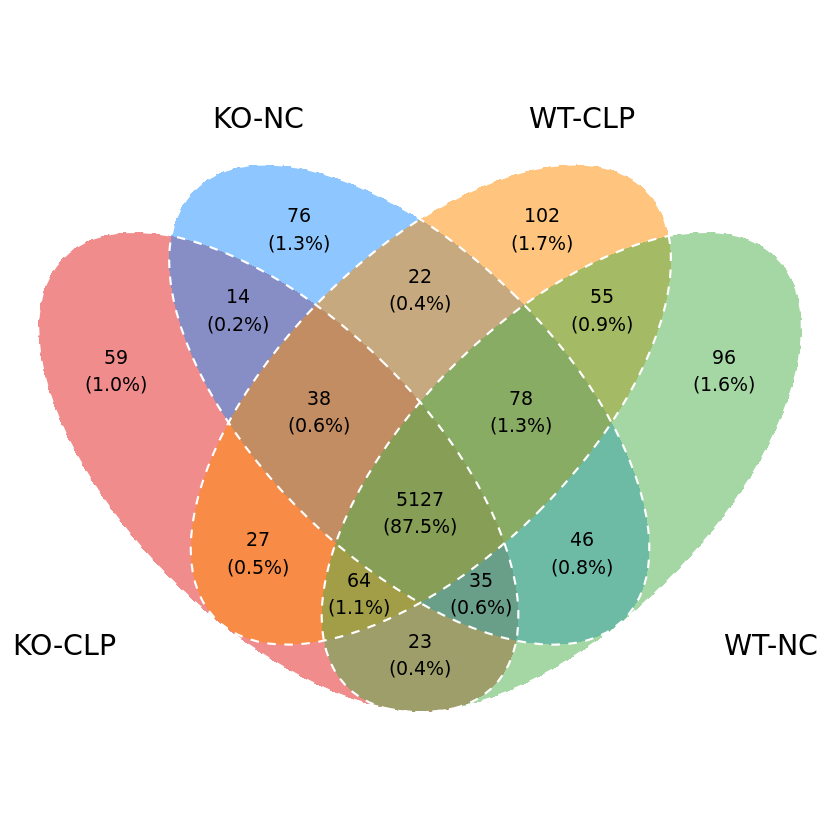

In [49]:
### 参考链接 韦恩图  https://www.jianshu.com/p/11e00258a88c
otu= tibble::rownames_to_column(reads, 'ID')
df = otu %>% pivot_longer(-ID) %>%
  filter(value !=0) %>% rename(sample=name)
colnames(metadata)[1] = 'sample'
groups = list()
out = list()
for (i in unique(metadata$group)){
    groups[[i]] <- df %>% left_join(metadata,by="sample") %>% filter(group==i)
    out[[i]] = groups[[i]]$ID
    }
out %>% 
  ggvenn(show_percentage = T,show_elements = F,label_sep = ",",
         digits = 1,stroke_color = "white",stroke_alpha=1,
         stroke_size=0.6,
         stroke_linetype="dashed",
         fill_color = c("#E41A1C", "#1E90FF", "#FF8C00",
                        "#4DAF4A", "#984EA3")  
         #,set_name_color = c("#E41A1C", "#1E90FF","#FF8C00","#4DAF4A")
        )
ggsave(file = paste0(outdir,'/','species_number_venn.pdf'),width = 8,height = 8)
ggsave(file = paste0(outdir,'/','species_number_venn.png'),width = 8,height = 8)

In [56]:
# carbom_abund <- filter_taxa(carbom, function(x) sum(x > total*0.01) > 0, TRUE)
# pdf(paste0(outdir,'/OTU_heatmap.pdf'),width = 12,height = 5)
# plot_heatmap(carbom_abund, method = "NMDS", distance = "bray")
# dev.off()
# png(paste0(outdir,'/OTU_heatmap.png'),width = 12,height = 5)
# plot_heatmap(carbom_abund, method = "NMDS", distance = "bray")
# dev.off()

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 41 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 2 sample variables ]
tax_table()   Taxonomy Table:    [ 41 taxa by 7 taxonomic ranks ]

png 
  2

png 
  2

### 分组LEFse

In [67]:
outdir

[1] "/data/workdirV6/1.Species_level"

In [68]:
compare = read.table('./compare.txt',header =T)

In [69]:
compare_pairs = paste(outdir,"compare_pairs",sep = "/")
if(dir.exists(compare_pairs)){
  print("dir exists")
}else{
  dir.create(compare_pairs)
}

[1] "dir exists"


In [110]:
sample = read.table('./sample.txt',header =T,sep = '\t')
for (i in compare$Test){
    compare_pair = sample %>% filter (group %in%  strsplit(i,'vs')[[1]])
    print(compare_pair)
    compare_pair$sample = gsub('-','.',compare_pair$sample)
    # compare_pair$sample = paste0(compare_pair$sample,'.S.bracken')
    write.table(compare_pair,file = paste0(compare_pairs,'/',i,'.txt'),quote = F,row.names = F,sep = '\t')
OTU = carbom@otu_table
TAX = carbom@tax_table
OTU %<>% data.frame()
mm = i
mm = gsub('-','.',mm)
OTU1 = select(OTU, contains(strsplit(mm,'vs')[[1]]))
metadata <- import_qiime_sample_data(paste0(compare_pairs,'/',i,'.txt'))
OTU1 = otu_table(OTU1,taxa_are_rows = TRUE)
carbom_test <- phyloseq(OTU1, TAX,metadata)    
### lefse分析
carbom_test <- phyloseq::rarefy_even_depth(carbom_test,rngseed=1000)
set.seed(1000)
diffres <- diff_analysis(carbom_test, classgroup="group",
padjust = "fdr",#p值校正方法
filtermod = "pvalue",#以pvalue列过滤
firstcomfun = "kruskal.test",
firstalpha=0.05, strictmod=TRUE,
secondcomfun = "wilcox.test",
mlfun = "lda",#线性判别分析，可选随机森林
subclmin=3, subclwilc=TRUE,
secondalpha=0.05, ldascore=3)

mycolor = c(
            "#998B95" ,"#5E549A" ,"#8952A0", "#4552A0",
            "#384B97" ,"#2B3B72" ,"#911310",
            "#384C99" ,"#9B8E8C" ,"#7CA878" ,"#35A132",
    "#B84D64" ,"#864A68" ,"#EE7072", "#E32D32" )

ggdiffclade(obj=diffres,
            layout="circular",#布局类型
            alpha=0.3, #树分支的背景透明度
            linewd=0.2, #树中连线粗细
            skpointsize=0.8, #树骨架中国点的大小
            taxlevel=2, #要展示的树分支水平2（门）及3以下（纲目科属种）
            cladetext=4,#文本大小
            setColors=F,#自定义颜色
            removeUnknown=T,#不删分支，但移除分类中有un_的物种注释
            reduce=T)+scale_fill_manual(values=c("#00AED7", "#FD9347")) +
  guides(color = guide_legend(keywidth = 0.1, keyheight = 0.6,order = 3,ncol=1)) +
  theme(panel.background=element_rect(fill=NA),
    legend.position="right", 
    plot.margin=margin(0,0,0,0),
    legend.spacing.y=unit(0.02, "cm"), 
    legend.title=element_text(size=12),
    legend.text=element_text(size=10), 
    legend.box.spacing=unit(0.02,"cm"))

output = paste(compare_pairs,i,sep = "/")
if(dir.exists(output)){
  print("dir exists")
}else{
  dir.create(output)
}
    
ggsave(file = paste0(output,'/','LEFse_tree.pdf'),width = 10,height = 8)
ggsave(file = paste0(output,'/','LEFse_tree.png'),width = 10,height = 8)

diffbox <- ggdiffbox(obj=diffres, box_notch=FALSE, 
                     l_xlabtext="relative abundance",
                    colorlist=c("#00AED7", "#FD9347"))
diffbox
ggsave(file = paste0(output,'/','LEFse_boxplot.pdf'),width = 8,height = 8)
ggsave(file = paste0(output,'/','LEFse_boxplot.png'),width = 8,height = 8)

effectsize <- ggeffectsize(obj=diffres, lineheight=0.1,linewidth=0.3,pointsize=3) + 
  scale_color_manual(values=c("#00AED7", "#FD9347")) 
effectsize
ggsave(file = paste0(output,'/','LEFse_dot.pdf'),width = 6,height = 12)
ggsave(file = paste0(output,'/','LEFse_dot.png'),width = 6,height = 12)

ggdifftaxbar(obj=diffres, xtextsize=1.5, 
             output=paste0('1.Species_level','/',"compare_pairs/",i,'/each_biomarkder_barplot'),
             coloslist=c("#00AED7", "#FD9347"))

write.csv(diffres@result,file = paste0(output,'/','diff-0.05.final.csv'),row.names = F)

#### 保存diffres
saveRDS(diffres,file = paste0(output,'/','diffres.rds'))

    
}

    sample  group
1  KO-CLP1 KO-CLP
2  KO-CLP2 KO-CLP
3  KO-CLP3 KO-CLP
4  KO-CLP4 KO-CLP
5  KO-CLP5 KO-CLP
6  KO-CLP6 KO-CLP
7  KO-CLP7 KO-CLP
8  KO-CLP8 KO-CLP
9  WT-CLP1 WT-CLP
10 WT-CLP2 WT-CLP
11 WT-CLP3 WT-CLP
12 WT-CLP4 WT-CLP
13 WT-CLP5 WT-CLP
14 WT-CLP6 WT-CLP
15 WT-CLP7 WT-CLP
16 WT-CLP8 WT-CLP


`set.seed(1000)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1000); .Random.seed` for the full vector

...

279OTUs were removed because they are no longer 
present in any sample after random subsampling


...

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

The color has been set automatically, you can reset it manually by adding scale_fill_manual(values=yourcolors)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "dir exists"


The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


   sample group
1  KO-NC1 KO-NC
2  KO-NC2 KO-NC
3  KO-NC3 KO-NC
4  KO-NC4 KO-NC
5  KO-NC5 KO-NC
6  KO-NC6 KO-NC
7  KO-NC7 KO-NC
8  KO-NC8 KO-NC
9  WT-NC1 WT-NC
10 WT-NC2 WT-NC
11 WT-NC3 WT-NC
12 WT-NC4 WT-NC
13 WT-NC5 WT-NC
14 WT-NC6 WT-NC
15 WT-NC7 WT-NC
16 WT-NC8 WT-NC


`set.seed(1000)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1000); .Random.seed` for the full vector

...

242OTUs were removed because they are no longer 
present in any sample after random subsampling


...

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

The color has been set automatically, you can reset it manually by adding scale_fill_manual(values=yourcolors)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "dir exists"


The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


    sample  group
1  WT-CLP1 WT-CLP
2  WT-CLP2 WT-CLP
3  WT-CLP3 WT-CLP
4  WT-CLP4 WT-CLP
5  WT-CLP5 WT-CLP
6  WT-CLP6 WT-CLP
7  WT-CLP7 WT-CLP
8  WT-CLP8 WT-CLP
9   WT-NC1  WT-NC
10  WT-NC2  WT-NC
11  WT-NC3  WT-NC
12  WT-NC4  WT-NC
13  WT-NC5  WT-NC
14  WT-NC6  WT-NC
15  WT-NC7  WT-NC
16  WT-NC8  WT-NC


`set.seed(1000)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1000); .Random.seed` for the full vector

...

204OTUs were removed because they are no longer 
present in any sample after random subsampling


...

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

The color has been set automatically, you can reset it manually by adding scale_fill_manual(values=yourcolors)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "dir exists"


The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


    sample  group
1  KO-CLP1 KO-CLP
2  KO-CLP2 KO-CLP
3  KO-CLP3 KO-CLP
4  KO-CLP4 KO-CLP
5  KO-CLP5 KO-CLP
6  KO-CLP6 KO-CLP
7  KO-CLP7 KO-CLP
8  KO-CLP8 KO-CLP
9   KO-NC1  KO-NC
10  KO-NC2  KO-NC
11  KO-NC3  KO-NC
12  KO-NC4  KO-NC
13  KO-NC5  KO-NC
14  KO-NC6  KO-NC
15  KO-NC7  KO-NC
16  KO-NC8  KO-NC


`set.seed(1000)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1000); .Random.seed` for the full vector

...

320OTUs were removed because they are no longer 
present in any sample after random subsampling


...

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

The color has been set automatically, you can reset it manually by adding scale_fill_manual(values=yourcolors)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "dir exists"


The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
The color has been set automatically, you can reset it manually by adding scale_color_manual(values=yourcolors)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


### 这是物种层面的脚本，还可以根据课题进展解释物种丰度之间的相关性

In [132]:
set.seed(1000)
diffres <- diff_analysis(carbom, classgroup="group",
padjust = "fdr",#p值校正方法
filtermod = "pvalue",#以pvalue列过滤
firstcomfun = "kruskal.test",
firstalpha=0.05, strictmod=TRUE,
secondcomfun = "wilcox.test",
mlfun = "lda",#线性判别分析，可选随机森林
subclmin=3, subclwilc=TRUE,
secondalpha=0.05, ldascore=3)

In [134]:
write.csv(diffres@originalD,file = './4.cor/species.df.csv')

### 调整 species

In [6]:
OTU = carbom@otu_table
TAX = carbom@tax_table

In [7]:
TAX = as.data.frame(TAX)
TAX$Species = paste0(TAX$Genus,'_',TAX$Species)

In [8]:
TAX = as.matrix(TAX)

In [9]:
TAX1 = phyloseq::tax_table(TAX)

In [10]:
metadata <- import_qiime_sample_data("./sample.txt")

In [11]:
carbomnew <- phyloseq(OTU, TAX1,metadata)  

In [12]:
type = rank_names(carbomnew)
for (i in c(1,2,3,4,5,6,7)){
    carbomnew@sam_data[["group"]]<-factor(carbomnew@sam_data[["group"]],levels = c("WT-NC", "KO-NC", "WT-CLP", "KO-CLP"))
    phytax <- get_taxadf(obj=carbomnew, taxlevel=i)
    phybar <- ggbartax(obj=phytax,facetNames="group", count=FALSE) +
      xlab(NULL) + ylab("relative abundance (%)")+
      theme(axis.text.x=element_text(face="plain",
                                     color="black",hjust=0.8,vjust=0.6,
                                     size=9, angle=90))+
      theme(strip.text.x = element_text(size=8, color="black",
                                        face="plain"))+
      theme(legend.position="right")
phybar
# ggsave(file = paste0(outdir,'/',type[i],'_heatmap.pdf'),width = 10,height = 5)
# ggsave(file = paste0(outdir,'/',type[i],'_heatmap.png'),width = 10,height = 5)
}


The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)



In [13]:
tax = as.data.frame(phytax@tax_table)

In [14]:
OTU = phytax@otu_table

In [15]:
TAX = as.data.frame(tax)
TAX$Species = paste0(TAX$Genus,'_',TAX$Species)

In [ ]:
rownames(TAX) = TAX$Species

TAX = as.matrix(TAX)

TAX1 = phyloseq::tax_table(TAX)

OTU = as.data.frame(OTU)

rownames(OTU) = rownames(TAX)

In [21]:
groupinfo = read.table('./sample.txt',header =T)

In [22]:
df = rownames_to_column(as.data.frame(t(OTU)),'sample')
df2 = merge(groupinfo,df,by = 'sample')
df2 = df2[,-1]
library(collapse)
f1 <- function(x) sum(x, na.rm = TRUE)
df3 = collap(df2, ~ group, FUN = f1)
df4 =  tibble::column_to_rownames(df3,var = 'group')
df4 = as.data.frame(df4)

Warning message:
“package ‘collapse’ was built under R version 4.2.3”
collapse 1.9.6, see ?`collapse-package` or ?`collapse-documentation`


Attaching package: ‘collapse’


The following object is masked from ‘package:stats’:

    D




In [23]:
df5 = as.data.frame(t(df4))

In [24]:
OTU1 = otu_table(df5,taxa_are_rows = T)

In [25]:
metadata = data.frame(sample = c('KO-CLP','KO-NC','WT-CLP','WT-NC'),
                     group = c('KO-CLP','KO-NC','WT-CLP','WT-NC'))

In [26]:
rownames(metadata) = metadata$group

In [27]:
meta = sample_data(metadata)

In [28]:
phytax2 <- phyloseq(OTU1, TAX1,meta)  

In [122]:
write.csv(as.data.frame(phytax2@otu_table),file = './4.cor/rename.species.expr.csv')

In [29]:
 phybar <- ggbartax(obj=phytax2,facetNames="group", count=FALSE) +
      xlab(NULL) + ylab("relative abundance (%)")+
      theme(axis.text.x=element_text(face="plain",
                                     color="black",hjust=0.8,vjust=0.6,
                                     size=9, angle=90))+
      theme(strip.text.x = element_text(size=8, color="black",
                                        face="plain"))+
      theme(legend.position="right")

The color has been set automatically, you can reset it 
            manually by adding scale_fill_manual(values=yourcolors)



In [31]:
options(repr.plot.height = 8,repr.plot.width = 14)

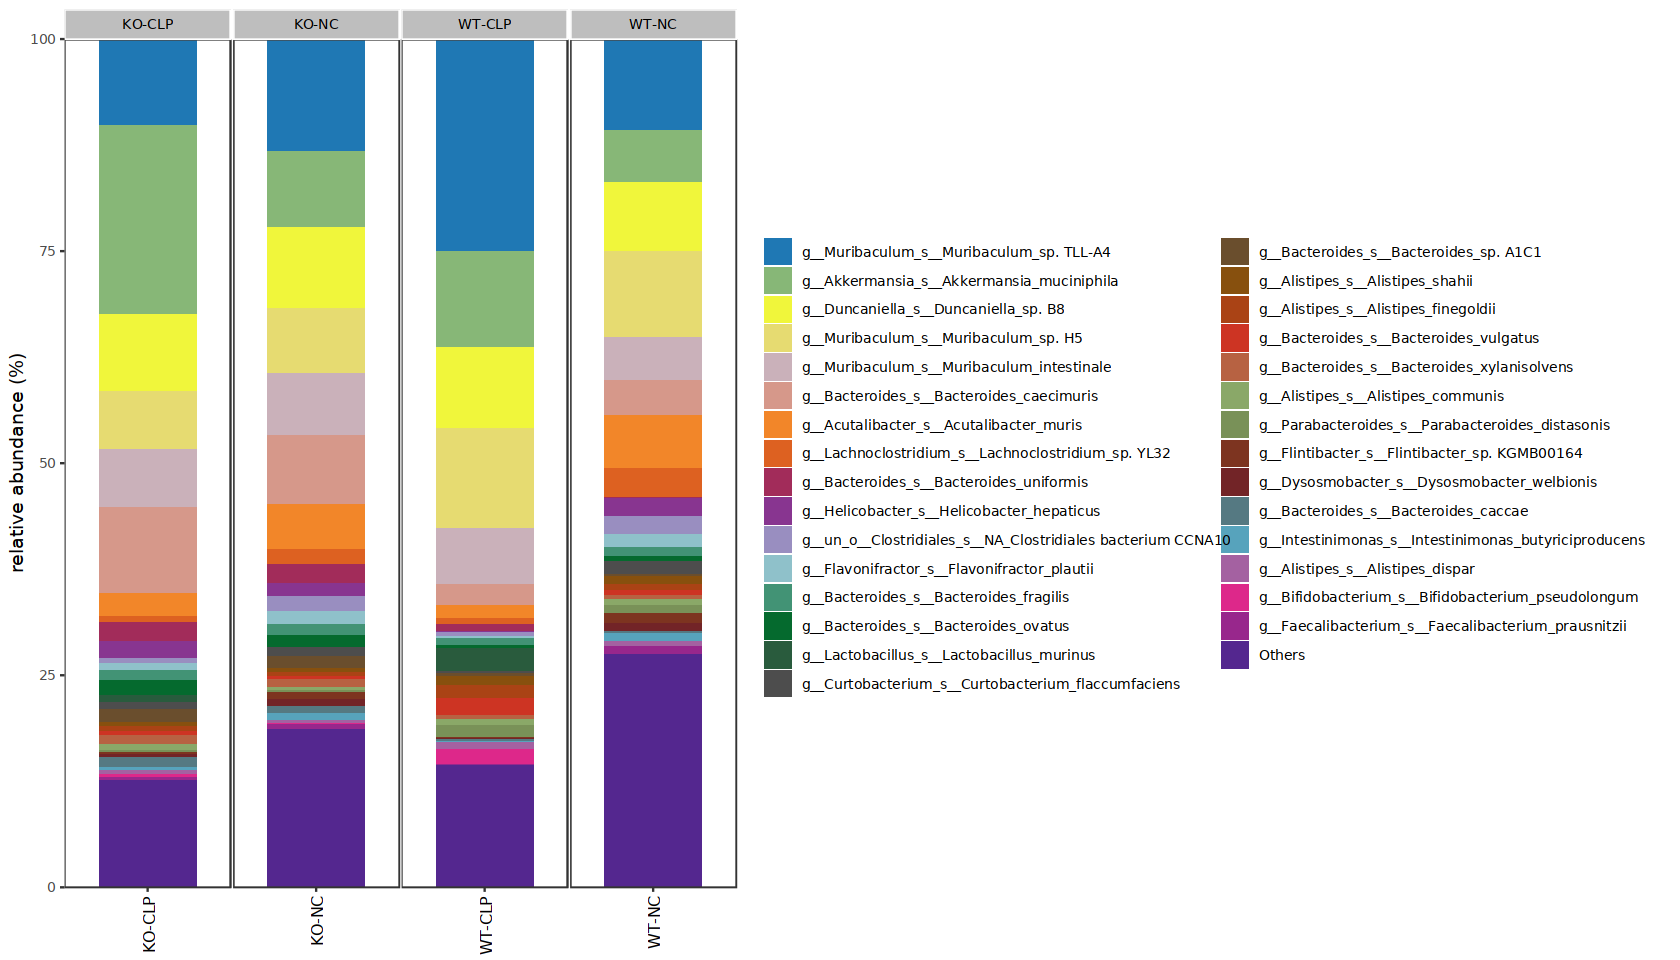

In [32]:
phybar
# ggsave(file = paste0(outdir,'/',type[7],'_heatmap.pdf'),width = 14,height = 5)
# ggsave(file = paste0(outdir,'/',type[7],'_heatmap.png'),width = 14,height = 5)

In [377]:
write.csv(as.data.frame(TAX),file ='taxname.csv')

In [48]:
write.csv(as.data.frame(phytax2@otu_table),file = 'reads_in_group.csv')

In [316]:
groupinfo = read.table('./sample.txt',header =T)
type = rank_names(carbom)
for (i in c(1,2,3,4,5,6,7)){ 
phytax <- get_taxadf(obj=carbom, taxlevel=i)
df = rownames_to_column(as.data.frame(t(as.data.frame(phytax@otu_table))),'sample')
df2 = merge(groupinfo,df,by = 'sample')
df2 = df2[,-1]
library(collapse)
f1 <- function(x) sum(x, na.rm = TRUE)
df3 = collap(df2, ~ group, FUN = f1)
df4 =  tibble::column_to_rownames(df3,var = 'group')
df4 = as.data.frame(df4)
write.csv(df4,file = paste0(outdir,'/',type[i],'.csv'))
    }

[1] "/data/workdirV6/1.Species_level"